We consider the following dynamics:
$$\begin{bmatrix}\dot x \\ \dot y \\ \dot \theta\end{bmatrix} = \begin{bmatrix}v\cos (\theta) \\ v\sin (\theta) \\ u\end{bmatrix},$$ 
with states $x, y, \theta$ and control $u$. $v$ is the uncertain parameter

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib
import pickle as pkl

from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import hj_reachability as hj
# from parent repo import utils
import sys
sys.path.append('..') 
#import utils
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from cbf_opt import ControlAffineDynamics, BatchedDynamics, ControlAffineASIF
from experiment_wrapper import RolloutTrajectory, StateSpaceExperiment, TimeSeriesExperiment
from refine_cbfs import HJControlAffineDynamics, TabularControlAffineCBF, utils

init_notebook_mode(connected=True)

In [3]:
class Obstacle:
    def __init__(self, type, stateIndices) -> None:
        self.type = type
        self.stateIndices = stateIndices

class Rectangle(Obstacle):
    def __init__(self, stateIndices, minVal, maxVal) -> None:
        super().__init__("Rectangle", stateIndices)
        self.minVal = jnp.reshape(np.array(minVal), (-1, 1))
        self.maxVal = jnp.reshape(np.array(maxVal), (-1, 1))

    def obstacle_sdf(self, x):
        max_dist_per_dim = jnp.max(
            jnp.array(
                [
                    self.minVal -
                    jnp.reshape(x[..., self.stateIndices], (-1, 1)),
                    jnp.reshape(x[..., self.stateIndices],
                                (-1, 1)) - self.maxVal,
                ]
            ),
           axis=0,
        )

        def outside_obstacle(_):
            return jnp.linalg.norm(jnp.maximum(max_dist_per_dim, 0))

        def inside_obstacle(_):
            return jnp.max(max_dist_per_dim)

        obstacle_sdf = (
            jax.lax.cond(jnp.all(max_dist_per_dim < 0.0),
                         inside_obstacle, outside_obstacle, operand=None)
        )
        return obstacle_sdf

In [4]:
from numpy import ndarray


class Dubins(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']

    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state: ndarray, time: float = 0.0) -> ndarray:
        return jnp.array([self.params['v'] * jnp.cos(state[2]),
                          self.params['v'] * jnp.sin(state[2]),
                          0.0])
    
    def control_matrix(self, state, time: float = 0.0) -> ndarray:
        return jnp.array([[0.0], [0.0], [1.0]])

In [5]:
from numpy import ndarray


class Dubins_dist(ControlAffineDynamics):
    STATES = ['X', 'Y', 'THETA']
    CONTROLS = ['OMEGA']
    DISTURBANCES = ['v']
    def __init__(self, params, **kwargs):
        super().__init__(params, **kwargs)

    def open_loop_dynamics(self, state: ndarray, time: float = 0.0) -> ndarray:
        return jnp.array([0.0, 0.0, 0.0])
    
    def control_matrix(self, state, time: float = 0.0) -> ndarray:
        return jnp.array([[0.0], [0.0], [1.0]])
    
    def disturbance_matrix(self, state: ndarray, time: float = 0) -> ndarray:
       return jnp.array([[jnp.cos(state[2])], [jnp.sin(state[2])], [0]])

In [6]:
umax = 0.5
obstacle = Rectangle([0, 1], [4.0, -2.0], [6.0, 2.0])
target = jnp.array([[9.0, 4.0, 0.0]])
dyn = Dubins(params={'v': [0.5, 1.0]}, dt=0.01)
batched_dyn = BatchedDynamics(dyn)
rollout_dyn = Dubins(params={'v': 0.75}, dt=0.01)
rollout_batched_dyn = BatchedDynamics(rollout_dyn)
dyn_hjr = HJControlAffineDynamics(dyn, control_space=hj.sets.Box(jnp.array([-umax]), jnp.array([umax])))
nominal_controller = lambda t: lambda x, time: jnp.clip(
    jnp.mod(jnp.arctan2(x[:,1] - t[:,1], x[:,0] - t[:,0]) - x[:,2], 2 * jnp.pi) - jnp.pi, -umax, umax)

In [30]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=hj.sets.Box(lo=jnp.array([0.0, -5.0, -jnp.pi]), hi=jnp.array([10.0, 5.0, jnp.pi])),
    shape=(101, 101, 101),
    periodic_dims=2
)

visualization_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain=hj.sets.Box(lo=jnp.array([0.0, -5.0]), hi=jnp.array([10.0, 5.0])),
    shape=(101, 101),
)

In [31]:
sdf_values = hj.utils.multivmap(obstacle.obstacle_sdf, jnp.arange(grid.ndim))(grid.states)

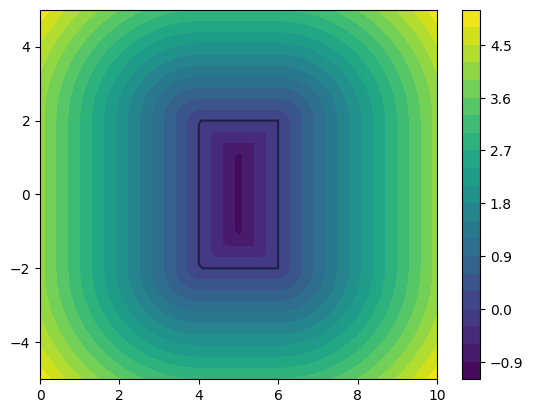

In [32]:
cf = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=20)
# add colorbar
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], colors='k', alpha=0.5)
plt.colorbar(cf)
hj.viz.visFunc(visualization_grid, sdf_values[:,:,0])  # toggle 
#hj.viz.visFunc(grid_dist, sdf_values_dist)

## Reachability based work
First we will just do it offline

In [34]:
backwards_reachable_tube = lambda obstacle: (lambda t, x: jnp.minimum(x, obstacle))
solver_settings = hj.SolverSettings.with_accuracy("high", value_postprocessor=backwards_reachable_tube(sdf_values))
times = jnp.linspace(0, -10.0, 31)

In [35]:
from refine_cbfs import utils

Intersected value function of the extremas (v = 0.5 and 1)

In [36]:
target_values = utils.hj_solve(solver_settings, dyn_hjr, grid, times, sdf_values)


100%|##########| 10.0000/10.0 [00:09<00:00,  1.10sim_s/s]
100%|##########| 10.0000/10.0 [00:12<00:00,  1.23s/sim_s]


value function @ extremas and bounded disturbance

In [37]:
dyn_ext1 = Dubins(params={'v': 0.5}, dt=0.01)
dyn_ext2 = Dubins(params={'v': 1.0}, dt=0.01)
dyn_dist = Dubins_dist(params={}, dt=0.01)
dyn_hjr_ext1 = HJControlAffineDynamics(dyn_ext1, control_space=hj.sets.Box(jnp.array([-umax]), jnp.array([umax])))
dyn_hjr_ext2 = HJControlAffineDynamics(dyn_ext2, control_space=hj.sets.Box(jnp.array([-umax]), jnp.array([umax])))
dyn_hjr_dist = HJControlAffineDynamics(dyn_dist, control_space=hj.sets.Box(jnp.array([-umax]), jnp.array([umax])), disturbance_space=hj.sets.Box(jnp.array([0.5]), jnp.array([1.0])))

In [38]:
batched_dyn_ext1 = BatchedDynamics(dyn_ext1)
batched_dyn_ext2 = BatchedDynamics(dyn_ext2)
batched_dyn_dist = BatchedDynamics(dyn_dist)

In [39]:
target_values_ext1 = utils.hj_solve(solver_settings, dyn_hjr_ext1, grid, times, sdf_values)
target_values_ext2 = utils.hj_solve(solver_settings, dyn_hjr_ext2, grid, times, sdf_values)
target_values_dist = utils.hj_solve(solver_settings, dyn_hjr_dist, grid, times, sdf_values)

100%|##########| 10.0000/10.0 [00:08<00:00,  1.15sim_s/s]
100%|##########| 10.0000/10.0 [00:12<00:00,  1.21s/sim_s]
100%|##########| 10.0000/10.0 [00:13<00:00,  1.33s/sim_s]


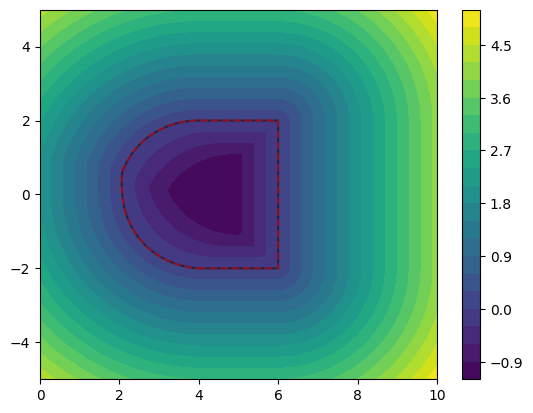

In [40]:
cf = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,50].T, levels=20)
# add colorbar
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,50].T, levels=[0], colors='k', alpha=0.5)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values_dist[-1][:,:,50].T, levels=[0], colors='red', alpha=0.5, linestyles='dashed')
plt.colorbar(cf)
hj.viz.visFunc(visualization_grid, target_values[-1][:,:,50])  # toggle 
#hj.viz.visFunc(grid_dist, sdf_values_dist)

In [45]:
tabular_cbf = TabularControlAffineCBF(batched_dyn, grid=grid)
tabular_cbf.vf_table = np.array(target_values[-1])

tabular_cbf_ext1 = TabularControlAffineCBF(batched_dyn_ext1, grid=grid)
tabular_cbf_ext1.vf_table = np.array(target_values_ext1[-1])

tabular_cbf_ext2 = TabularControlAffineCBF(batched_dyn_ext2, grid=grid)
tabular_cbf_ext2.vf_table = np.array(target_values_ext2[-1])

tabular_cbf_dist = TabularControlAffineCBF(batched_dyn_dist, grid=grid)
tabular_cbf_dist.vf_table = np.array(target_values_dist[-1])


In [46]:
x0 = jnp.array([0.0, -1.0, -jnp.pi / 6])
n_sims_per_start = 1
t_sim = 10.0
alpha = lambda x: 5.0 * x

In [63]:
dubins_asif = ControlAffineASIF(batched_dyn, tabular_cbf, alpha=lambda x: x, nominal_policy=nominal_controller(target),
                                umin=jnp.array([-umax]), umax=jnp.array([umax]), test=False)

dubins_asif_ext1 = ControlAffineASIF(batched_dyn_ext1, tabular_cbf_ext1, alpha=lambda x: x, nominal_policy=nominal_controller(target),
                                umin=jnp.array([-umax]), umax=jnp.array([umax]), test=False)

dubins_asif_ext2 = ControlAffineASIF(batched_dyn_ext2, tabular_cbf_ext2, alpha=lambda x: x, nominal_policy=nominal_controller(target),
                                umin=jnp.array([-umax]), umax=jnp.array([umax]), test=False)

dubins_asif_dist = ControlAffineASIF(batched_dyn_dist, tabular_cbf_dist, alpha=lambda x: x, nominal_policy=nominal_controller(target),
                                umin=jnp.array([-umax]), umax=jnp.array([umax]), dmin=jnp.array([0.5]), dmax=jnp.array([1.0]), test=False)

In [64]:
experiment = RolloutTrajectory('dubins', start_x=x0, n_sims_per_start=n_sims_per_start, t_sim=t_sim)

Case 0: Disturbance case

In [145]:
import itertools

class AdverserialDisturbance:
    def __init__(self, bounds, cbf, **kwargs):
        self.bounds = bounds
        self.cbf = cbf
    
    def __call__(self, x, t):
        # Compute optimal adverserial disturbance
        _, _ , Lw_h = self.cbf.lie_derivatives(x, t)
        possible_disturbances = np.array([p for p in itertools.product(*zip(self.bounds[0], self.bounds[1]))])
        if x.ndim == 1:
            x = x[None, ...]
        for i in range(x.shape[0]):
            # Set disturbance as the most atagonistic one
            disturbances = np.einsum("ik,jk->ij", Lw_h[i], possible_disturbances)
            return possible_disturbances[np.argmin(disturbances)]

In [157]:
dist = AdverserialDisturbance(bounds=np.array([[0.5], [1.0]]), cbf=tabular_cbf_dist)
dist2 = AdverserialDisturbance(bounds=np.array([[1.0], [1.0]]), cbf=tabular_cbf_dist)

In [162]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(batched_dyn_dist, {'Nominal': nominal_controller(target), "Disturbance": dubins_asif_dist, "param": dubins_asif}, disturbances={"disturbance": dist, "max": dist2})

Controller rollout: 100%|██████████| 1000/1000 [00:59<00:00, 16.75it/s]


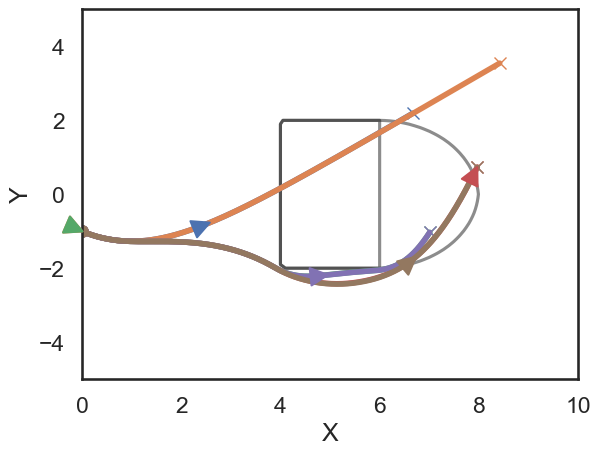

In [165]:
ss_exp = StateSpaceExperiment('quad', x_indices=[0, 1], start_x=x0)
fig, ax = plt.subplots()
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], 
            colors='k', alpha=0.5)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,0].T, levels=[0], colors='k', alpha=0.5)
ss_exp.plot(batched_dyn, results_df, ax=ax);

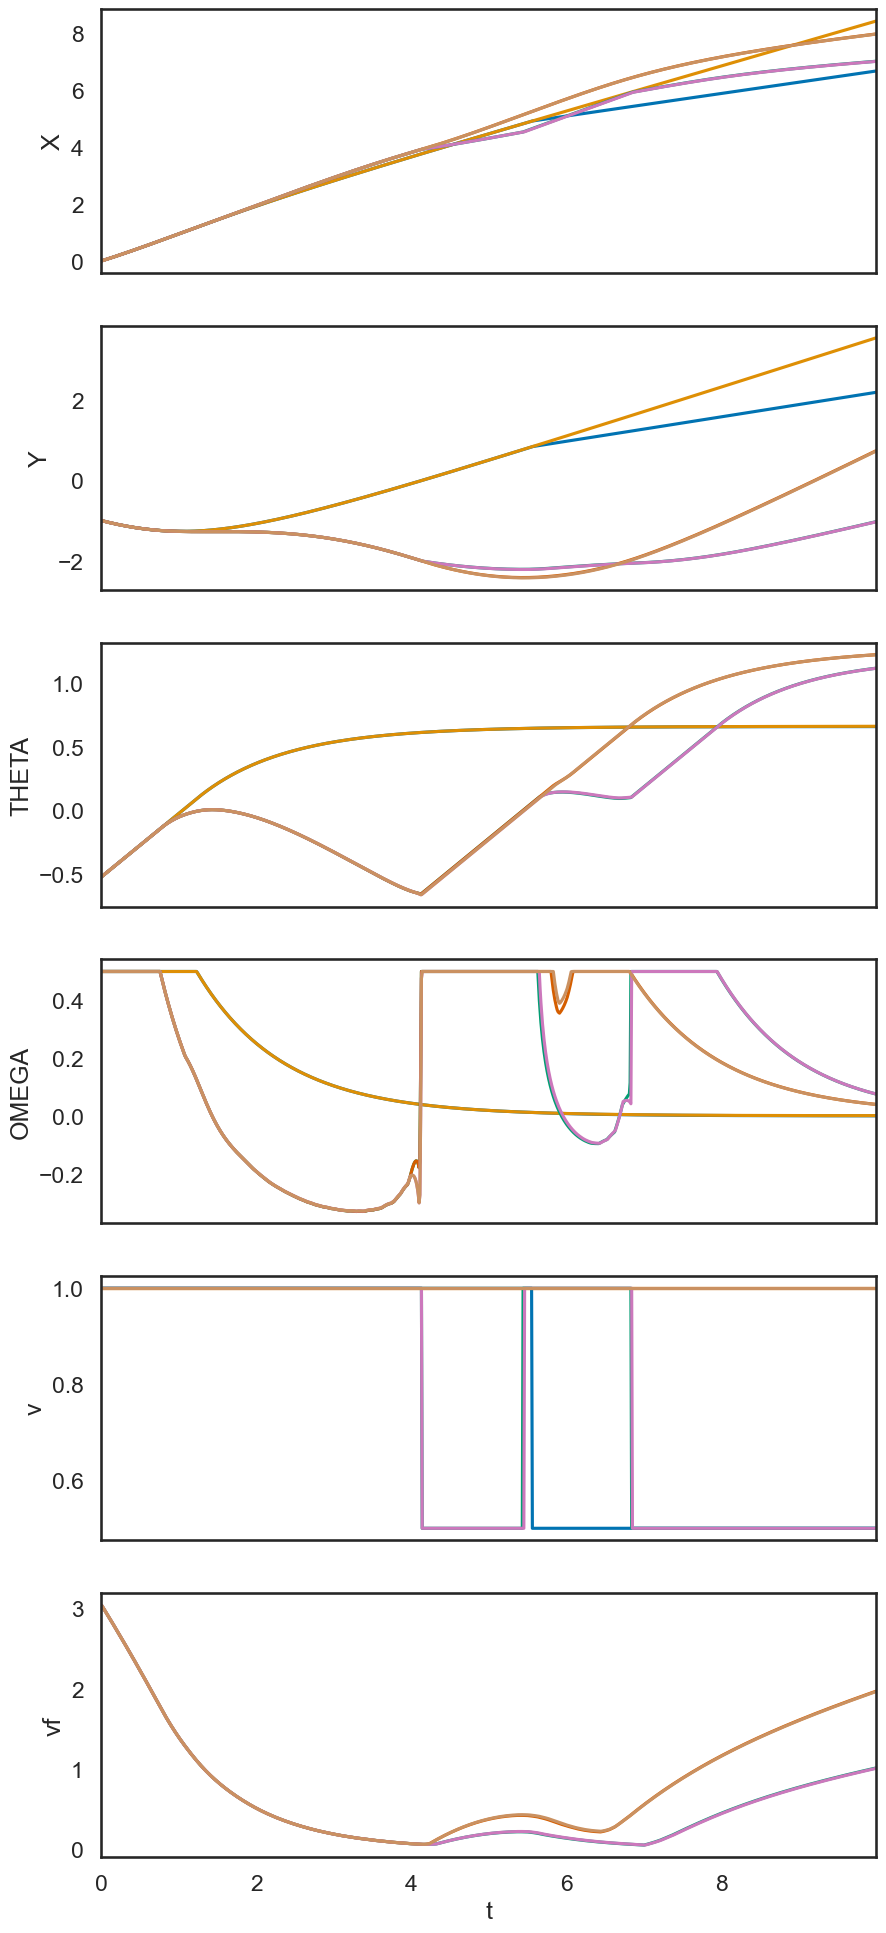

In [166]:
ts_exp = TimeSeriesExperiment('quad', start_x=x0)
ts_exp.plot(batched_dyn, results_df, extra_measurements=['v', 'vf']);

Bounded disturbance rollout for comparison:

Case 1: v = 0.75
We compare 3 trajectories:
1. Intserection of extrema value function (dubins_asif)
2. Bounded disturbance
3. Nominal controller (nominal)

In [72]:
import logging
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(rollout_batched_dyn, {'Nominal': nominal_controller(target), 'Parameteric': dubins_asif, "Disturbance": dubins_asif_dist})

Controller rollout: 100%|██████████| 1000/1000 [00:32<00:00, 31.04it/s]


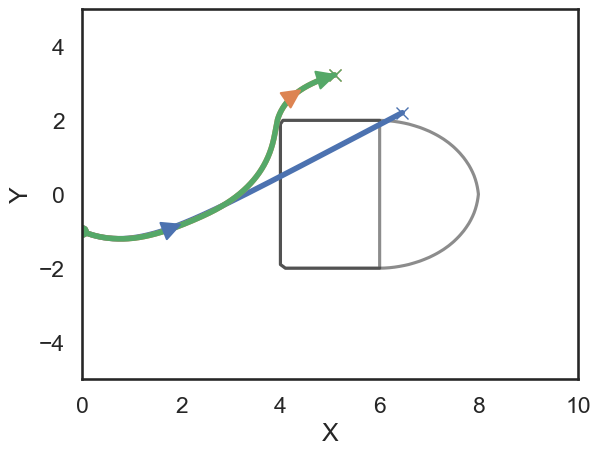

In [73]:
ss_exp = StateSpaceExperiment('quad', x_indices=[0, 1], start_x=x0)
fig, ax = plt.subplots()
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], 
            colors='k', alpha=0.5)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,0].T, levels=[0], colors='k', alpha=0.5)
ss_exp.plot(batched_dyn, results_df, ax=ax);

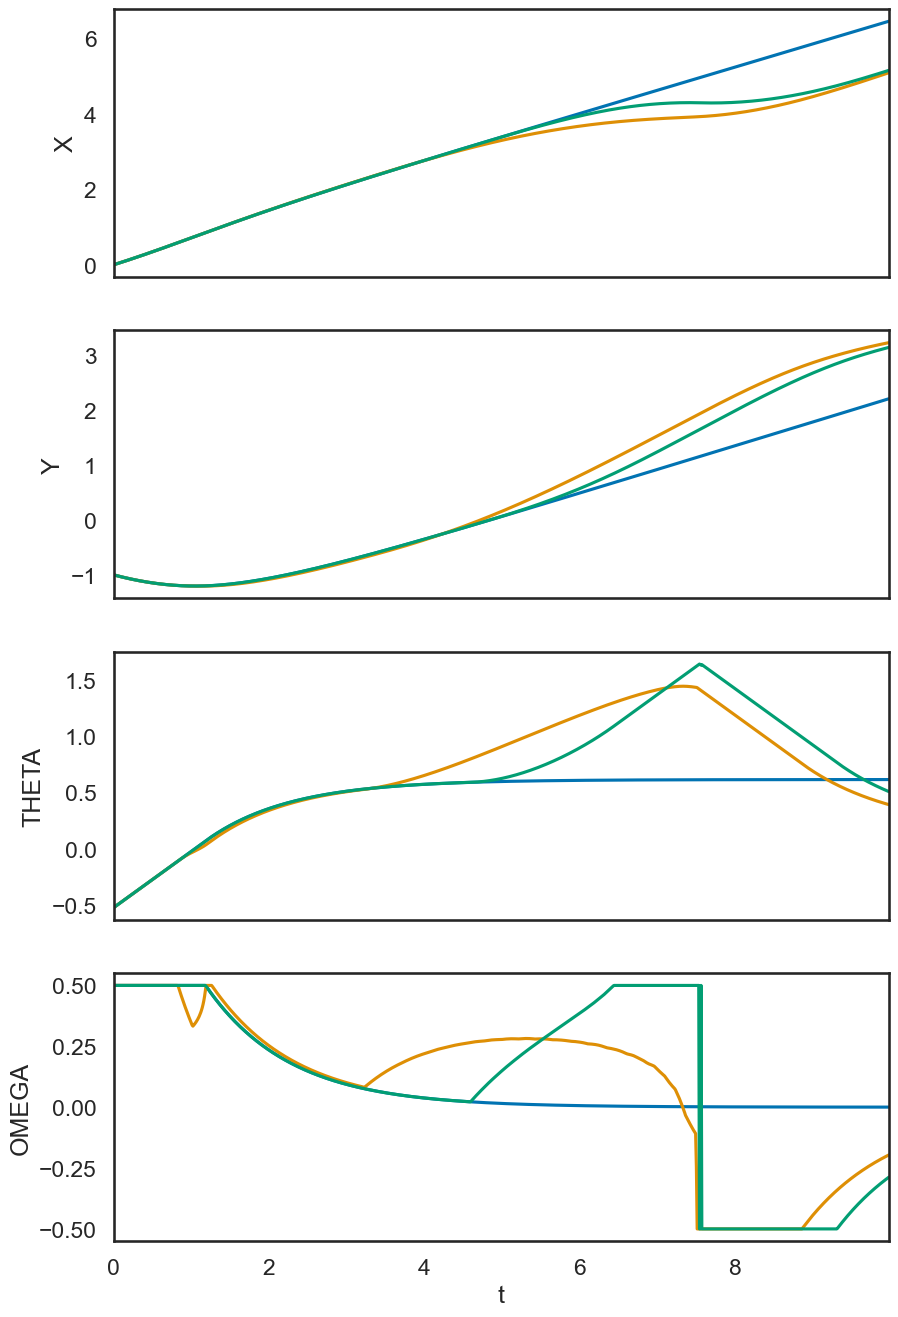

In [54]:
ts_exp = TimeSeriesExperiment('quad', start_x=x0)
ts_exp.plot(batched_dyn, results_df);

Case 2: v = 1
We compare 4 trajectories:
1. Intserection of extrema value function (dubins_asif)
2. Bounded disturbance
3. Nominal controller (nominal)
4. Value function of fixed param

In [ ]:
import logging
rollout_batched_dyn.params = {'v': 1.0}
rollout_batched_dyn.dyn.params = {'v': 1.0}
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(rollout_batched_dyn, {'Nominal': nominal_controller(target), 'Analytical': dubins_asif, 'Analytical2': dubins_asif_ext2})

In [ ]:
ss_exp = StateSpaceExperiment('quad', x_indices=[0, 1], start_x=x0)
fig, ax = plt.subplots()
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], 
            colors='k', alpha=0.5)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,50].T, levels=[0], colors='k', alpha=0.5)
ss_exp.plot(batched_dyn, results_df, ax=ax)

Case 3: v = 0.5
We compare 4 trajectories:
1. Intserection of extrema value function (dubins_asif)
2. Bounded disturbance
3. Nominal controller (nominal)
4. Value function of fixed param

In [ ]:
import logging
rollout_batched_dyn.params = {'v': 0.5}
rollout_batched_dyn.dyn.params = {'v': 0.5}
logging.getLogger('cbf_opt').setLevel(level=logging.ERROR)  # Surpresses warnings
results_df = experiment.run(rollout_batched_dyn, {'Nominal': nominal_controller(target), 'Analytical': dubins_asif, 'Analytical2': dubins_asif_ext1})

In [ ]:
ss_exp = StateSpaceExperiment('quad', x_indices=[0, 1], start_x=x0)
fig, ax = plt.subplots()
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], 
            colors='k', alpha=0.5)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], target_values[-1][:,:,50].T, levels=[0], colors='k', alpha=0.5)
ss_exp.plot(batched_dyn, results_df, ax=ax)